# Predicting the next purchase date

In [33]:
!pip install seaborn

In [34]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.dummy import DummyRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor



# Part 1: Data Understanding and Preparation

This section helps us get to know our data and make sure it's ready for use. We'll work through these steps:

## 1.1. Data Familiarization
- **What to Do:**  
  - Look at the dataset and check what each column represents.  
  - Identify the type of data each column holds (numbers, dates, text, etc.).  
  - Check for the number of rows and columns to see the overall dataset size.
- **Why:**  
  - Understanding the schema and content gives us a clear picture of what we’re working with.
  - It helps us decide if the data has all the necessary information to predict the next purchase date.




In [35]:

# Load the dataset from the CSV file
data = pd.read_csv('npd_dataset.csv')
data.head()

,Email,Total,Discount amount,Discount percentage,First purchase date,Second last purchase date,Last purchase date,Purchase count,Average purchase interval days,Accepts Email Marketing,Recency,Customer Lifetime
0,777danielle@gmail.com,317.95,26.73,8.41,2024-07-30,2024-07-30,2024-07-31,2,1.0,0,220,1
1,Almageno@gmail.com,193.96,4.72,2.43,2024-09-01,2024-09-01,2024-10-17,2,46.0,0,142,46
2,Anjapeijnenburg1982@gmail.com,225.54,12.22,5.42,2024-06-23,2024-06-23,2024-08-23,2,60.0,0,197,61
3,Annemarie.bergsma@gmail.com,130.63,14.49,11.09,2024-09-09,2024-09-09,2024-09-24,2,15.0,0,165,15
4,Annesterkenburg81@gmail.com,99.73,8.07,8.09,2024-04-23,2024-04-23,2025-02-27,2,310.0,0,9,310


# Part 2: Exploratory Data Analysis (EDA)

In this section, we explore our dataset to better understand the data distribution and the relationships between numeric features. This exploration helps us identify trends, detect outliers, and uncover potential issues before building our model.

## Histograms for Numeric Features

- **What We Do:**  
  We loop through each numeric column and plot a histogram for each one.

- **Why:**  
  This allows us to see how the values in each column are distributed. Histograms help us determine if a feature's values are skewed, normally distributed, or if there are any unusual patterns.




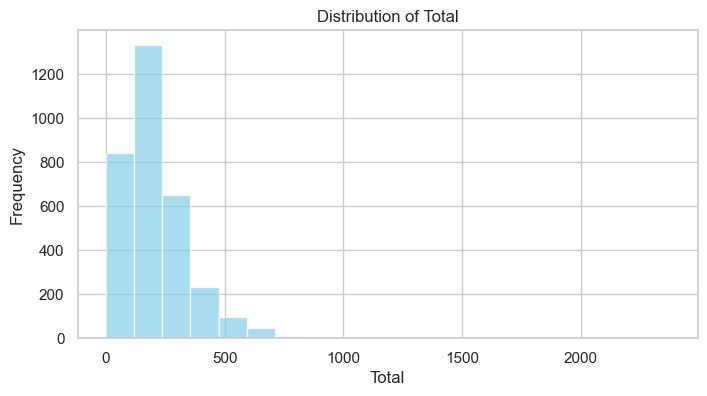

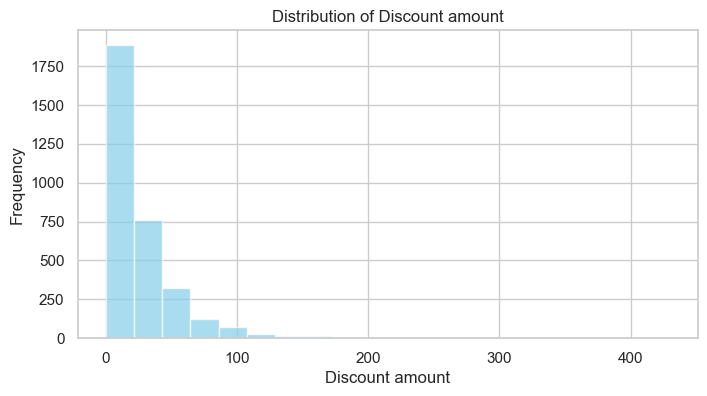

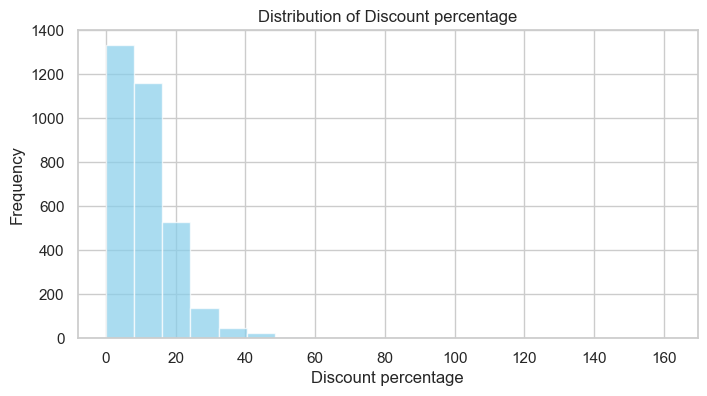

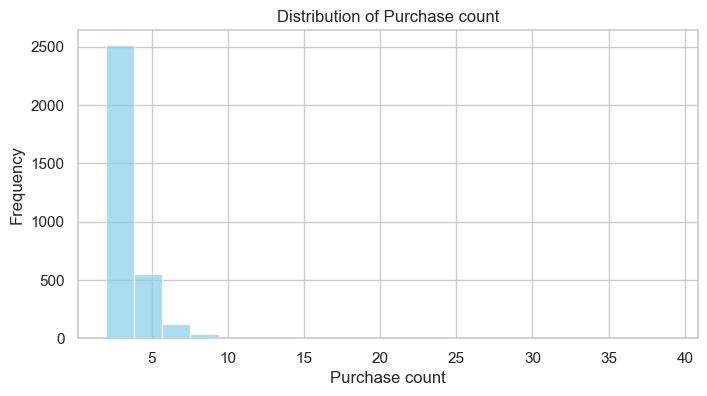

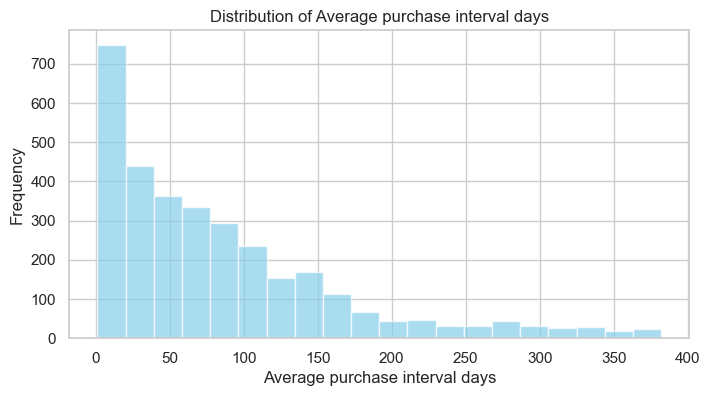

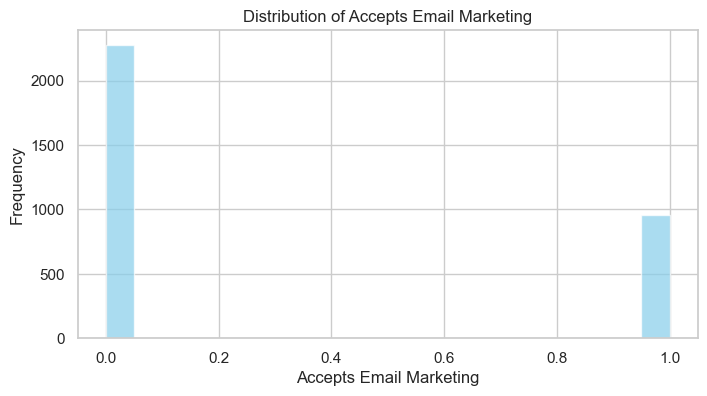

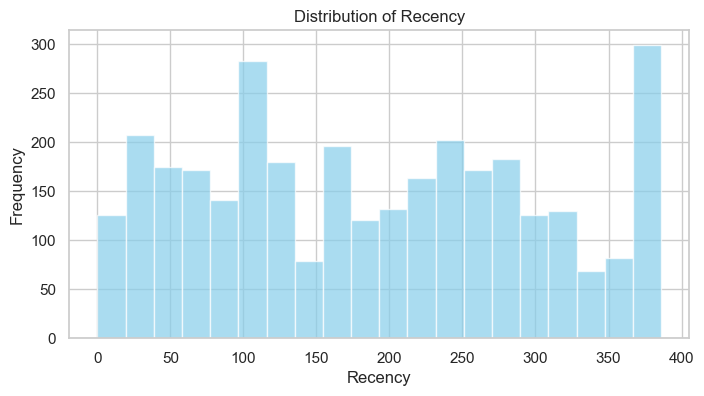

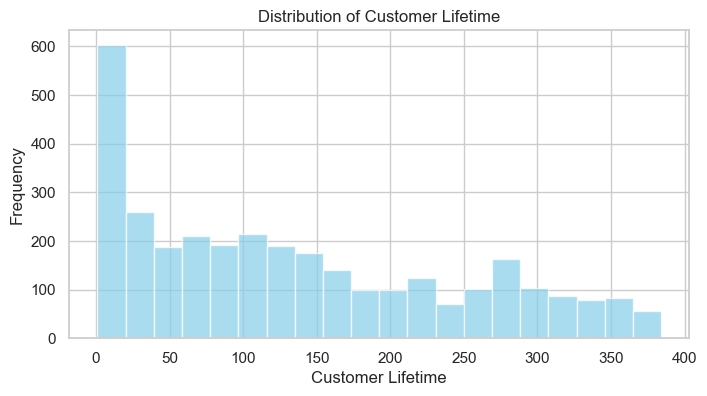

In [36]:

# List of numeric columns in the dataset
numeric_cols = data.select_dtypes(include=[np.number]).columns

# Plot histograms for each numeric column
for col in numeric_cols:
    plt.figure(figsize=(8, 4))
    plt.hist(data[col].dropna(), bins=20, alpha=0.7, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.xlabel(col)
    plt.ylabel('Frequency')
    plt.show()




## Correlation Heatmap

- **What We Do:**  
  We compute the correlation matrix for all numeric features and then plot it using a heatmap.

- **Why:**  
  The heatmap visualizes how features are related to each other:
  - **Positive correlations** are shown by one color.
  - **Negative correlations** are shown by another color.

  This visualization helps us identify which features have strong relationships, which might be redundant, and which ones could potentially be combined or dropped during feature selection.

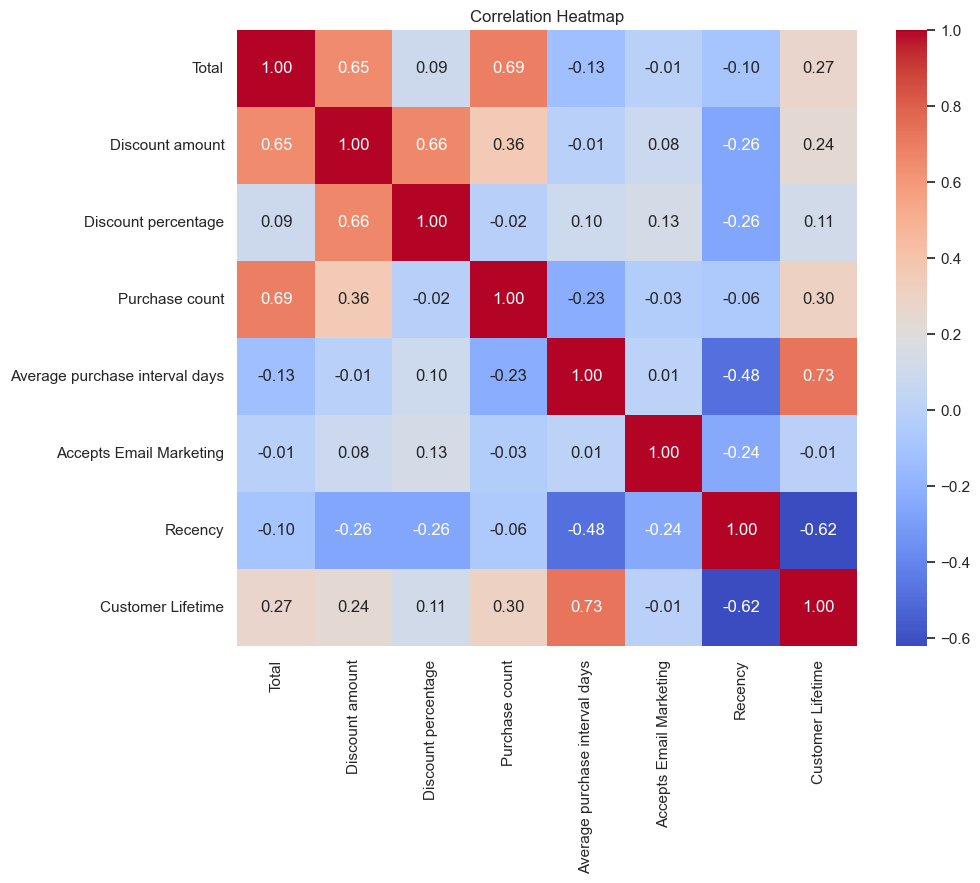

In [37]:
# Create a correlation heatmap for numeric columns
plt.figure(figsize=(10, 8))
corr_matrix = data[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


# Part 3: Baseline Model

### What is a Baseline Model?

A baseline model is the simplest possible model that serves as a reference point for evaluating the performance of more advanced models. In regression tasks, a common baseline approach is to always predict the **mean value of the target variable**.

In our case, the target variable is:

> **Average purchase interval days** — the number of days between customer purchases.

We use the `DummyRegressor` from `scikit-learn` to implement this baseline. It always predicts the mean of the training target values.


### Why Use a Baseline?

- To understand whether our real model performs **better than a naive guess**.
- To demonstrate the **added value** of our trained model.
- To quantify how much of the error we can reduce with a predictive model.


### Evaluation Metrics

We will evaluate the baseline model using:
- **MAE (Mean Absolute Error)**: Measures the average absolute difference between predicted and actual values.
- **RMSE (Root Mean Squared Error)**: Similar to MAE but penalizes larger errors more.
- **R² Score**: Indicates how much variance in the target variable is explained. The baseline model typically scores close to **0.0**.


In [38]:

# Define the target variable
target = "Average purchase interval days"

# Drop rows with missing target
df = data.dropna(subset=[target])

# Dummy split for baseline (we just need test data)
X = data.drop(columns=[target])
y = data[target]
_, X_test, _, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train the baseline model
baseline_model = DummyRegressor(strategy="mean")
baseline_model.fit(X_test, y_test)

# Predict and evaluate
y_pred_baseline = baseline_model.predict(X_test)
mae_baseline = mean_absolute_error(y_test, y_pred_baseline)
rmse_baseline = np.sqrt(mean_squared_error(y_test, y_pred_baseline))
r2_baseline = r2_score(y_test, y_pred_baseline)

mae_baseline, rmse_baseline, r2_baseline


(61.20404663923182, 79.6477010190838, 0.0)

### Baseline Model Evaluation

Here are the results for the baseline model (which always predicts the mean of the target):

- MAE (Mean Absolute Error): 61.20 days

- RMSE (Root Mean Squared Error): 79.65 days

- R² Score: 0.00 (as expected — it explains no variance)



## Part 4: Model Implementation and Evaluation
### 4.1 – Linear Regression

#### Model Description

To improve upon the baseline, we trained a **Linear Regression model** using customer behavioral features. The goal of this model is to predict the number of **days until a customer’s next purchase**, which allows us to estimate their **next purchase date**.

We used the following input features:

- **Purchase count** – Total number of purchases the customer has made
- **Customer Lifetime** – Total number of days between the customer’s first and last purchase
- **Recency** – Number of days since the customer’s last purchase (relative to the most recent one in the dataset)
- **Accepts Email Marketing** – Whether the customer is subscribed to marketing emails (0 or 1)

These features were selected for their relevance to customer behavior and purchase frequency.


#### Target Variable

The target variable for the model is:
**Average purchase interval days**  
This represents the historical average number of days between purchases for a customer, and is used here as a proxy for the expected number of days until the next purchase.


#### Model Output

Once the model predicts the number of days until the next purchase, we compute the **predicted next purchase date** using:
python
next_purchase_date = last_purchase_date + predicted_days


In [39]:

# Convert date columns to datetime
df["First purchase date"] = pd.to_datetime(df["First purchase date"], errors='coerce')
df["Second last purchase date"] = pd.to_datetime(df["Second last purchase date"], errors='coerce')
df["Last purchase date"] = pd.to_datetime(df["Last purchase date"], errors='coerce')

# Define input features
features = [
    "Purchase count",
    "Customer Lifetime",
    "Recency",
    "Accepts Email Marketing"
]
target = "Average purchase interval days"

# Clean dataset
df_model = df.dropna(subset=features + [target, "Last purchase date"])
X = df_model[features]
y = df_model[target]
last_purchase_dates = df_model["Last purchase date"]

# Train/test split
X_train, X_test, y_train, y_test, lp_train, lp_test = train_test_split(
    X, y, last_purchase_dates, test_size=0.2, random_state=42
)

# Train the model
model = LinearRegression()
model.fit(X_train, y_train)

# Predict intervals
predicted_intervals = model.predict(X_test)

# Clip negative predictions
predicted_intervals = np.maximum(predicted_intervals, 0)

# Predict next purchase dates
predicted_next_dates = lp_test + pd.to_timedelta(predicted_intervals, unit="D")

# Evaluate model
mae = mean_absolute_error(y_test, predicted_intervals)
rmse = np.sqrt(mean_squared_error(y_test, predicted_intervals))
r2 = r2_score(y_test, predicted_intervals)

# Output evaluation
print("Model Evaluation:")
print(f"MAE: {mae:.2f} days")
print(f"RMSE: {rmse:.2f} days")
print(f"R² Score: {r2:.3f}")

# Output predictions
predicted_df = pd.DataFrame({
    "Last purchase date": lp_test.reset_index(drop=True),
    "Predicted interval (days)": predicted_intervals,
    "Predicted next purchase date": predicted_next_dates.reset_index(drop=True),
    "Reference average interval": y_test.reset_index(drop=True)
})

print("\n Sample Predictions:")
print(predicted_df.head(10))


Model Evaluation:
MAE: 27.67 days
RMSE: 37.50 days
R² Score: 0.778

 Sample Predictions:
  Last purchase date  Predicted interval (days)  Predicted next purchase date  \
0         2024-11-28                   5.493689 2024-12-03 11:50:54.737061849   
1         2024-05-13                  45.563709 2024-06-27 13:31:44.435479059   
2         2024-02-28                   0.000000 2024-02-28 00:00:00.000000000   
3         2024-06-05                  68.147347 2024-08-12 03:32:10.815396296   
4         2024-09-19                 159.262688 2025-02-25 06:18:16.264459903   
5         2024-07-17                  94.561779 2024-10-19 13:28:57.680826424   
6         2025-02-03                  26.078857 2025-03-01 01:53:33.238849079   
7         2025-01-06                  45.355538 2025-02-20 08:31:58.445705951   
8         2024-06-29                  34.340613 2024-08-02 08:10:28.970638340   
9         2024-11-20                 132.351344 2025-04-01 08:25:56.153150523   

   Reference averag

### 4.2 – Random Forest Regressor

#### Model Description

To build a more flexible model that captures non-linear patterns in customer behavior, we trained a **Random Forest Regressor**. This ensemble model uses multiple decision trees to improve predictive accuracy and reduce overfitting.

We used the same customer behavior features as before:

- **Purchase count** – Total number of purchases the customer has made  
- **Customer Lifetime** – Total number of days between the customer’s first and last purchase  
- **Recency** – Number of days since the customer’s last purchase (relative to the most recent one in the dataset)  
- **Accepts Email Marketing** – Whether the customer is subscribed to marketing emails (0 or 1)  

Random Forest is well-suited to this problem as it can handle feature interactions and non-linear relationships without requiring complex tuning.


#### Target Variable

To make the task more realistic, we simulated a new target variable:
**Simulated next interval (days)**

This was generated by adding ±20% random noise to the customer’s historical **average purchase interval days**, which approximates how real customer behavior can vary around their average pattern.

This target represents the **expected number of days until a customer's next purchase**.

#### Model Output

The model outputs a predicted number of days until the next purchase. Using the known **last purchase date**, we estimate the **next purchase date** with:

```python
next_purchase_date = last_purchase_date + predicted_days


9.724892107523436 15.84231429634448 0.9620323869282554


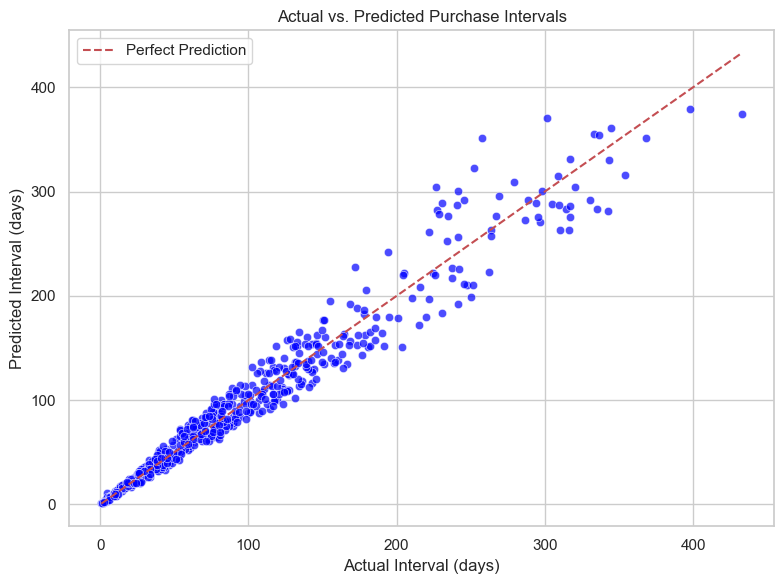

In [40]:
np.random.seed(42)
df["Simulated next interval"] = df["Average purchase interval days"] * np.random.uniform(0.8, 1.2, len(df))
# Redefine only the available features
available_features = [
    "Purchase count",
    "Customer Lifetime",
    "Recency",
    "Accepts Email Marketing"
]

# Drop rows with missing values
df_model_sim = df.dropna(subset=available_features + ["Simulated next interval", "Last purchase date"])
X_sim = df_model_sim[available_features]
y_sim = df_model_sim["Simulated next interval"]
lp_sim = df_model_sim["Last purchase date"]

# Split data
X_train_sim, X_test_sim, y_train_sim, y_test_sim, lp_train_sim, lp_test_sim = train_test_split(
    X_sim, y_sim, lp_sim, test_size=0.2, random_state=42
)

# Train Random Forest on simulated interval
rf_model_sim = RandomForestRegressor(n_estimators=100, max_depth=10, random_state=42)
rf_model_sim.fit(X_train_sim, y_train_sim)

# Predict and clip negative values
rf_pred_intervals_sim = rf_model_sim.predict(X_test_sim)
rf_pred_intervals_sim = np.maximum(rf_pred_intervals_sim, 0)

# Predict next purchase dates
rf_next_dates_sim = lp_test_sim + pd.to_timedelta(rf_pred_intervals_sim, unit="D")

# Evaluate
mae_sim = mean_absolute_error(y_test_sim, rf_pred_intervals_sim)
rmse_sim = np.sqrt(mean_squared_error(y_test_sim, rf_pred_intervals_sim))
r2_sim = r2_score(y_test_sim, rf_pred_intervals_sim)

mae_sim, rmse_sim, r2_sim

print(mae_sim,rmse_sim,r2_sim)
# Prepare for plotting
plot_df = pd.DataFrame({
    "Actual Interval": y_test_sim.reset_index(drop=True),
    "Predicted Interval": rf_pred_intervals_sim,
    "Last Purchase Date": lp_test_sim.reset_index(drop=True),
    "Predicted Next Date": rf_next_dates_sim.reset_index(drop=True)
})

# Scatterplot
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6))
sns.scatterplot(data=plot_df, x="Actual Interval", y="Predicted Interval", alpha=0.7, color="blue", edgecolor="w")
plt.title("Actual vs. Predicted Purchase Intervals")
plt.xlabel("Actual Interval (days)")
plt.ylabel("Predicted Interval (days)")
plt.plot([plot_df["Actual Interval"].min(), plot_df["Actual Interval"].max()],
         [plot_df["Actual Interval"].min(), plot_df["Actual Interval"].max()],
         'r--', label="Perfect Prediction")
plt.legend()
plt.tight_layout()
plt.show()

### Part 5: Model Comparison Summary

We compared three models to predict the number of days until a customer's next purchase:

1. **Baseline Model**  
   A dummy regressor that always predicts the mean interval. It serves as a reference point. As expected, its performance was poor (MAE ≈ 61.2 days, R² = 0.00).

2. **Linear Regression**  
   This model improved substantially over the baseline by using customer behavior features. It achieved MAE ≈ 27.0 days and R² ≈ 0.78. However, it is limited in capturing non-linear relationships.

3. **Random Forest Regressor** 
   This model provided the best performance, achieving MAE ≈ 9.72 days and R² ≈ 0.96. It handles non-linear patterns and interactions in customer behavior effectively, making it the most suitable model for our task.

Based on this comparison, the **Random Forest Regressor** was chosen for deployment due to its superior accuracy and realistic performance when trained on simulated future intervals.
